In [ ]:
%pip install scipy numpy matplotlib pingouin pandas xarray pathlib

### Utility functions

Run the cell below, but feel free to ignore this code — it’s some utility functions we’ll use later for convenience.

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
import scipy.optimize as opt
import numpy as np

def plot_signal_and_power_spectrum(time_vec, sig, freqs, psd):
    '''
    Makes figure with two subplots where the signal is plotted in one subplot and the power spectrum in the other

    Args:
        time_vec: array containing time points over which the signal is sampled
        sig: array containing signal
        freqs: frequencies for which the power spectral density is calculated
        psd: power spectral density of the signal
    '''
    fig, ax = plt.subplots(ncols=2, figsize=(7,4))

    ax[0].plot(time_vec, sig, label = 'Signal')
    ax[0].set(xlabel = 'Time (s)', ylabel = 'Amplitude', title = 'Signal')

    ax[1].loglog(freqs, psd, label = 'Power Spectrum')
    ax[1].set(xlabel = 'Frequency (Hz)', ylabel = 'Power spectral density (normalized)', title = 'Power spectrum')
    fig.tight_layout()

def red_noise_spectrum(freqs, A, beta):
    '''
    Estimates the power spectrum values as a function of frequency for a red noise signal

    Args:
        freqs: frequencies for which the power spectrum should be estimated
        A: Amplitude of power spectrum
        beta: Shape parameter for the function
    returns:
        spectrum: red noise power spectrum
    '''

    spectrum = A*(1.-beta**2)/(1.-2.*beta*np.cos(np.pi*(freqs)/freqs[-1])+beta**2)
    return spectrum

def get_significance_threshold_psd(function, freqs, psd_original, n_samples, n_perseg, alpha=0.05,):
    '''
    Gets threshold for statistical significance for a power spectrum given a certain p-value

    Args:
        function: function to fit to create equivalent spectrum for a signal only consisting of noise
        freqs: frequencies for which the power spectrum should has been estimated
        psd_original: power spectrum computed for signal
        n_samples: length of signal the power spectrum was calculated for
        n_perseg: number of points per segment in Welch's method
        alpha: p-value threshold for statistical significance
    Return:
        psd_expected: equivalent power spectrum if signal only contains noise (noise of the same colour as the original signal)
        psd_significance_threshold: threshold for power spectrum peak to be significant
    '''
    # Fit function to red noise equivalent spectrum(excluding very low frequencies)
    valid_idx = freqs > 0
    popt, _ = opt.curve_fit(function, freqs[valid_idx], psd_original[valid_idx])

    # Compute noise spectrum equivalent
    psd_expected = function(freqs, *popt)

    # calculate degrees of freedom (dof). dof = 2*number_of_samples/number_of_spectral_estimates = 2*len(your_signal)/n_perseg
    dof = 2*n_samples/n_perseg

    # Get Chi squared value for the threshold p-value
    chi_sq_threshold = chi2.ppf(1-alpha, dof)

    # Calculate the psd value at the threshold p-value
    psd_significance_threshold = psd_expected*chi_sq_threshold/(dof-1)

    return psd_expected, psd_significance_threshold

def get_p_value(idx_frequencies, psd_original, psd_expected, n_samples, n_perseg):
    """Calculates the p-values of the peaks at the selected frequencies"""

    # calculate degrees of freedom (dof)
    dof = 2*n_samples/n_perseg

    chi2_values = (dof-1)*psd_original[idx_frequencies]/psd_expected[idx_frequencies]

    # Compute p-values from chi-square CDF
    p_values = 1 - chi2.cdf(chi2_values, df=dof)

    return p_values

def plot_spectra_with_significance_threshold(freqs, psd_original, psd_expected, n_samples, n_perseg):
    '''
    Makes loglog plot of power spectrum together with red noise equivalant and thershold for significance. 
    Used to visualize which peaks are above statistically significant in a spectrum with a 1/f relationship

    Args:
        psd_original: power spectrum computed for signal
        psd_expected: equivalent power spectrum if signal only contains noise (noise of the same colour as the original signal)
        psd_significance_threshold: threshold for power spectrum peak to be significant
    '''
    # calculate degrees of freedom (dof)
    dof = 2*n_samples/n_perseg

    # Get Chi squared value for the threshold p-value
    chi_sq_threshold95 = chi2.ppf(0.95, dof)
    chi_sq_threshold99 = chi2.ppf(0.99, dof)

    # Calculate the psd value at the threshold p-value
    psd_significance_threshold95 = psd_expected*chi_sq_threshold95/(dof-1)
    psd_significance_threshold99 = psd_expected*chi_sq_threshold99/(dof-1)

    fig, ax = plt.subplots(figsize = (5,5))

    ax.loglog(freqs, psd_original, label = 'Original PSD')
    ax.loglog(freqs, psd_expected, '--', color = 'r', label = 'Red noise PSD')
    ax.loglog(freqs, psd_significance_threshold95, '--', color = 'g', label = f'95 % threshold')
    ax.loglog(freqs, psd_significance_threshold99, '--', color = 'black', label = f'99 % threshold')
    ax.set(xlabel = 'Frequency (Hz)', ylabel = 'Power spectral density (normalized)', title = 'Power spectrum of signal with\nthreshold for significance')
    fig.legend(bbox_to_anchor = (0.9, 0.9))

class utils:
    plot_signal_and_power_spectrum = plot_signal_and_power_spectrum
    red_noise_spectrum = red_noise_spectrum
    get_significance_threshold_psd = get_significance_threshold_psd
    get_p_value = get_p_value
    plot_spectra_with_significance_threshold = plot_spectra_with_significance_threshold

In [3]:
import xarray as xr
from pathlib import Path

## Download dataset

In [4]:
import owncloud
import os

if not os.path.exists('../../data'):
    print('Creating directory for data')
    os.mkdir('../data')

if not os.path.exists('../../data/dataset_session_754312389.nc'):
    print('Downloading data')
    owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/ZAs9uJ1KzrWi0ra').get_file('/', '../../data/dataset_session_754312389.nc')

#### Load dataset

Run cells below to load dataset and extract relevant data

In [5]:
loadpath = '../../data/dataset_session_754312389.nc'

dataset_path = Path(loadpath)

dataset = xr.load_dataset(dataset_path)
dataset

<xarray.Dataset> Size: 232MB
Dimensions:                             (channel_depth: 23,
                                         trial_stimulus_id: 75,
                                         time_from_stimulus_onset_lfp: 1875,
                                         time_from_stimulus_onset_csd: 1875,
                                         time_whole_rec: 373124,
                                         channel_depth_LM: 19,
                                         ...
                                         time_from_stimulus_onset_spikes: 1500,
                                         unit_id_V1: 91, unit_id_LM: 13,
                                         stimulus_start_times: 75,
                                         stimulus_stop_times: 75,
                                         channel_id: 23,
                                         time_from_stimulus_onset_lfp_trial: 1875)
Coordinates: (12/17)
  * channel_depth                       (channel_depth) int64 184B 0 ... -880
  * trial_stimulus_id                   (trial_stimulus_id) int32 300B 3649 ....
  * time_from_stimulus_onset_lfp        (time_from_stimulus_onset_lfp) float64 15kB ...
  * time_from_stimulus_onset_csd        (time_from_stimulus_onset_csd) float64 15kB ...
  * time_whole_rec                      (time_whole_rec) float64 3MB 1.286e+0...
  * channel_depth_LM                    (channel_depth_LM) int64 152B 0 ... -720
    ...                                  ...
  * unit_id_V1                          (unit_id_V1) int32 364B 951795075 ......
  * unit_id_LM                          (unit_id_LM) int32 52B 951791074 ... ...
  * stimulus_start_times                (stimulus_start_times) float64 600B 1...
  * stimulus_stop_times                 (stimulus_stop_times) float64 600B 1....
  * channel_id                          (channel_id) int32 92B 850144538 ... ...
  * time_from_stimulus_onset_lfp_trial  (time_from_stimulus_onset_lfp_trial) float64 15kB ...
Data variables:
    lfp_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_lfp) float64 26MB ...
    csd_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_csd) float64 26MB ...
    lfp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    ecp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    lfp_LM                              (channel_depth_LM, trial_stimulus_id_LM, time_from_stimulus_onset_LM_lfp) float64 11MB ...
    spike_counts_LGN                    (unit_id_LGN, trial_nr, time_from_stimulus_onset_spikes) int16 6MB ...
    spike_counts_V1                     (unit_id_V1, trial_nr, time_from_stimulus_onset_spikes) int16 20MB ...
    spike_counts_LM                     (unit_id_LM, trial_nr, time_from_stimulus_onset_spikes) int16 3MB ...
    pupil_width                         (trial_nr) float64 600B 39.12 ... 44.31
    run_speed                           (trial_nr) float64 600B 1.155 ... 1.711
Attributes:
    time_unit:                  millisecond
    lfp_unit:                   Volt
    channel_depth_unit:         micrometer
    note_channel_depth:         Measured in distance from electrode closest t...
    sampling_frequency_lfp:     1250
    sampling_frequency_spikes:  1000
    sampling_frequency_unit:    Hz

#### Extract LFP data

In [6]:
lfp_trials = dataset['lfp_trials']
lfp_whole_rec = dataset['lfp_whole_recording']
channels_depth = dataset['channel_depth']

sampling_frequency_lfp = dataset.sampling_frequency_lfp # Hz
time_lfp = lfp_trials.time_from_stimulus_onset_lfp.values # ms

# Introduction

It's not always clear which peaks in a power spectrum are simply due to noise and not. To help us determine which peaks are unlikely to just be noise, we can carry out statistical tests on the power spectra.

## Section 1

### Primer on statistical testing

T-tests can be used to compare the means of two samples of data from normally-distributed populations and compute the probability that the populations have the same mean.

| Code, | Statistical Test | Description |
| :-- | :-- | :-- |
| `pg.ttest(x, 0)` | One-Sampled T-Test | "Is the mean of my data unlikely to be zero?" |
| `pg.ttest(x, y)` | Independent-Samples T-Test | "Do the means of x and y indicate they are unlikely to be from the same distribution?" |
| `expected, observed, stats = pg.chi2_independence(data, x='col_name_A', y='col_name_B')` | $\chi^2$ test | Is x a predictor of y? `expected` gives expected values if x is NOT a predictor of y, `observed` gives actual observed values of y for different values of x, `stats` gives statistical results of $\chi^2$ test given these expected and observed values. |



In [7]:
import pingouin as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Generate Data**: Run the code below to create the dataset `height` containing fictional data on the height of a sample of 30 germans, 30 italians and 30 Dutch people.

<Axes: >

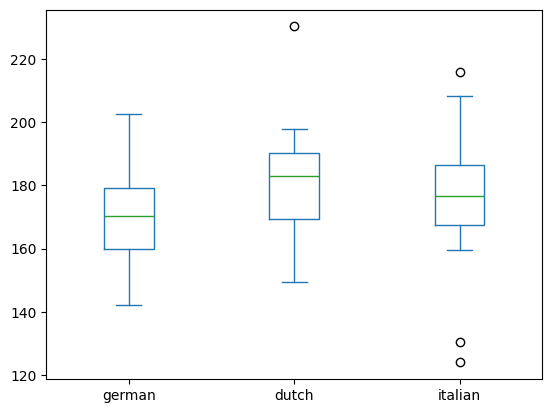

In [8]:
randomizer = np.random.RandomState(17)  # Makes sure the pseudorandom number generators reproduce the same data for us all.
height = pd.DataFrame()
height['german'] = randomizer.normal(0, 15, size=30)+170
height['dutch'] = randomizer.normal(0, 15, size=30)+180
height['italian'] = randomizer.normal(0, 15, size=30)+175
height.plot.box()

### Analyze the Data with T-Tests in Pingouin

**Example, Independent Samples T-Test**: Are the heights recorded for the germans and the dutch statistically different with p = .05 as the threshold for statistical significance?

In [9]:
pg.ttest(height['german'], height['dutch'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86907,58,two-sided,0.005734,"[-19.52, -3.48]",0.740791,7.346,0.805465


**Exercise, Independent Samples T-Test**: Are the heights recorded for the italians and the Dutch statistically different?

In [10]:
pg.ttest(height['italian'], height['dutch']) # no

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.116856,58,two-sided,0.268661,"[-13.82, 3.92]",0.288371,0.443,0.195583


**Exercise, Independent Samples T-Test**: Are the heights recorded for the germans and the italians statistically different?

In [11]:
pg.ttest(height['italian'], height['german']) # no

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.469208,58,two-sided,0.14718,"[-2.37, 15.48]",0.379348,0.646,0.30359


**Generate Data**: Run the code below to create the dataset `treatment` containing data from a fictional drug trial study. We'll use this data in the next couple of exercises.

<Axes: >

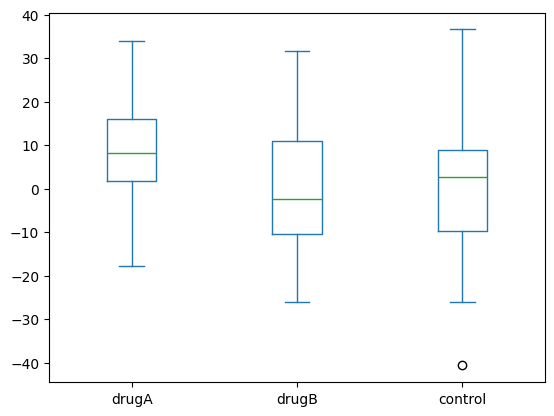

In [12]:
randomizer = np.random.RandomState(15)
treatment = pd.DataFrame()
treatment['drugA'] = randomizer.normal(0, 15, size=30)+10
treatment['drugB'] = randomizer.normal(0, 15, size=30)+1
treatment['control'] = randomizer.normal(0, 15, size=30)
treatment.plot.box()

**Exercise**: Perform a t-test to determine whether the treatment effect of drug A is statistically significant by comparing it to the control group.

In [13]:
pg.ttest(treatment['drugA'], treatment['control'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.221458,58,two-sided,0.030237,"[0.85, 16.32]",0.573578,2.0,0.588876


**Exercise**: Perform a t-test to determine whether the treatment effect of drug B is statistically significant by comparing it to the control group.

In [14]:
pg.ttest(treatment['drugB'], treatment['control'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.230379,58,two-sided,0.818608,"[-7.57, 9.54]",0.059484,0.268,0.055902


#### Dataset: The Passengers on the Titanic

below, we load a dataset containing (semi-fictitious) information about the passenger onboard Titanic.  Every row is a passenger, every column is a variable about that passenger.  Please run the code and take a look at the dataset.

In [15]:
titanic = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/refs/heads/master/titanic.csv')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


A $\chi^2$ test, like the t-test, can be used to test differences between groups. The difference lies in the use-cases - what kind of data the test is applied to. T-tests are applied when the dependent variable (for example height in the exercises above) is continuous. A $\chi^2$ test is applied when the dependent variable is categorical. In the exercises below, the dependent variable will be categorical. For example if a passenger on Titanic survived or did not survive is a categorical outcome - there's no degrees of survival, either they survived or they didn't. In such cases, a $\chi^2$ test should be used.

**Example**: Use a $\chi^2$ independence test to determine whether the chance of survival depended on which class a passenger traveled on. (You don't need to look at more than the first row of the output in these exercises.)

In [16]:
expected, observed, stats = pg.chi2_independence(titanic, x='class', y='survived')

stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,102.888989,2.0,4.549252e-23,0.339817,1.0
1,cressie-read,0.666667,102.741005,2.0,4.898625e-23,0.339573,1.0
2,log-likelihood,0.000000,103.547124,2.0,3.273615e-23,0.340902,1.0
3,freeman-tukey,-0.500000,105.128509,2.0,1.484685e-23,0.343496,1.0
4,mod-log-likelihood,-1.000000,107.580420,2.0,4.357212e-24,0.347478,1.0
5,neyman,-2.000000,115.324285,2.0,9.070888e-26,0.359767,1.0


**Exercise**: Did the chance of survival depend on sex?

In [17]:
expected, observed, stats = pg.chi2_independence(titanic, x='class', y='survived')

stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,102.888989,2.0,4.549252e-23,0.339817,1.0
1,cressie-read,0.666667,102.741005,2.0,4.898625e-23,0.339573,1.0
2,log-likelihood,0.000000,103.547124,2.0,3.273615e-23,0.340902,1.0
3,freeman-tukey,-0.500000,105.128509,2.0,1.484685e-23,0.343496,1.0
4,mod-log-likelihood,-1.000000,107.580420,2.0,4.357212e-24,0.347478,1.0
5,neyman,-2.000000,115.324285,2.0,9.070888e-26,0.359767,1.0


**Exercise**: Did the likelihood that a passenger was an adult male depend on which town they embarked from?

In [18]:
expected, observed, stats = pg.chi2_independence(titanic, x='embark_town', y='adult_male')

stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,11.053778,2.0,0.003978,0.111382,0.854413
1,cressie-read,0.666667,10.998406,2.0,0.004090,0.111103,0.852555
2,log-likelihood,0.000000,10.910445,2.0,0.004274,0.110658,0.849563
3,freeman-tukey,-0.500000,10.863804,2.0,0.004375,0.110421,0.847955
4,mod-log-likelihood,-1.000000,10.833262,2.0,0.004442,0.110266,0.846894
5,neyman,-2.000000,10.819259,2.0,0.004473,0.110194,0.846406


### Demo: How to find the p-value of a $\chi^2$ test by comparing to the $\chi^2$ distribution

As for the t-test, the p-value from a $\chi^2$ test is determined by comparing the $\chi^2$ score with a distribution of $\chi^2$ values. This distribution will tell you the probability of observing a certain $\chi^2$ score in a test. Below is an illustration of how this works. 

The green line represents the $\chi^2$ score obtained from the last test above. The orange line is the cumulative probability density function (CDF) of $\chi^2$ scores (for two degrees of freedom). The black line from the cross section between the CDF and the observed $\chi^2$ value tells you the probability of observing this $\chi^2$ value when traced to the y-axis. This probability is the p-value. As could also be seen from the table with the test result in the previous exercise above, the probability is only just above 0.

In the following sections, making comparisons to a $\chi^2$ distribution is how we determine whether peaks in the frequency spectra are statistically significant or not.

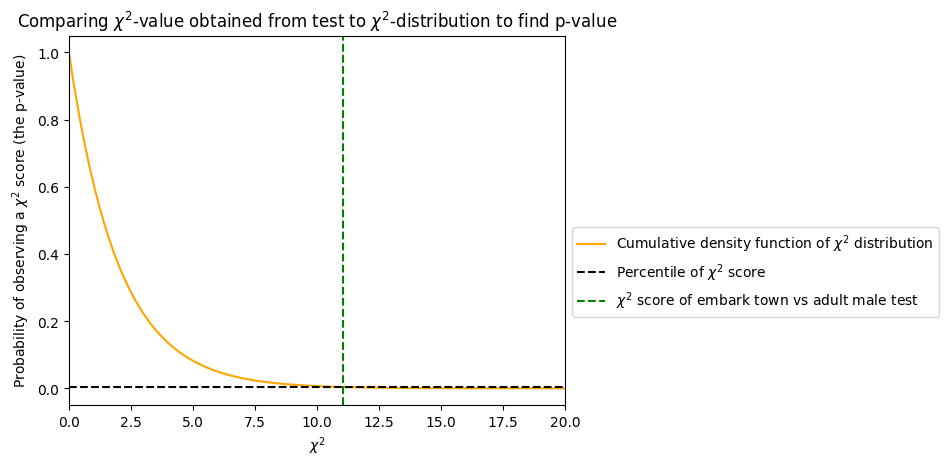

In [19]:
from scipy.stats import chi2

expected, observed, stats = pg.chi2_independence(titanic, x='embark_town', y='adult_male')

x = np.linspace(0,20,100)
plt.plot(x, 1-chi2.cdf(x, 2), color='orange', label = r'Cumulative density function of $\chi^2$ distribution')

idx = np.searchsorted(x, stats['chi2'][0])

plt.axhline(1-chi2.cdf(x, 2)[idx], ls = '--', color = 'black', label = r'Percentile of $\chi^2$ score')

plt.axvline(stats['chi2'][0], ls = '--', color = 'green', label = r'$\chi^2$ score of embark town vs adult male test')

plt.xlabel(r'$\chi^2$')
plt.ylabel(r'Probability of observing a $\chi^2$ score (the p-value)')
plt.title(r'Comparing $\chi^2$-value obtained from test to $\chi^2$-distribution to find p-value')

plt.xlim([0,20])

plt.legend(bbox_to_anchor = (1,0.5));

## Section 2

### Test the statistical significance of peaks in the power spectrum

It's not clear just from looking at a power spectrum which peaks are just due to noise and which represent an oscillation due to a neurological phenomenon. By comparing the power spectrum calculated for the LFP to the power spectrum computed for an equivalent red noise spectrum, we can better assess which peaks are due to noise and which are not.

| Code | Description |
| :-- | :-- |
| `freqs, psd = signal.welch(sig, fs = sampling_frequency, nperseg = some_num)` | Calculate the power spectral density (``psd``) of a signal `sig` using Welch's method. `nperseg` sets the number of samples of the signal in each segment, default value is 256. |
|``psd_expected, psd_significance_threshold = ``<br> &nbsp;&nbsp;&nbsp;&nbsp;``utils.get_significance_threshold_psd(``<br> &nbsp;&nbsp;&nbsp;&nbsp;``function, freqs, psd, n_perseg, n_samples, alpha)``| Get the threshold for a peak in the power spectrum `psd` to be significant at significance level `alpha`. For LFP, a function producing a red noise spectrum would typically be passed for `function`.  `psd_expected` is the expected spectrum if the signal only contains noise. |
|``utils.plot_spectra_with_significance_threshold(``<br> &nbsp;&nbsp;&nbsp;&nbsp;``freqs, psd_signal, psd_expected, ``<br> &nbsp;&nbsp;&nbsp;&nbsp;``psd_significance_threshold, n_perseg,``<br> &nbsp;&nbsp;&nbsp;&nbsp;``n_samples, alpha)``| Plot the power spectrum together with the threshold for peaks to be significant at significance level `alpha`. |

In [20]:
from scipy.stats import chi2
from scipy import signal
import scipy.optimize as opt

**Example**: A power spectrum is calculated for a generated signal in the cell below. Use an equivalent red noise spectrum to find and plot the threshold for statistically significant peaks in this power spectrum.

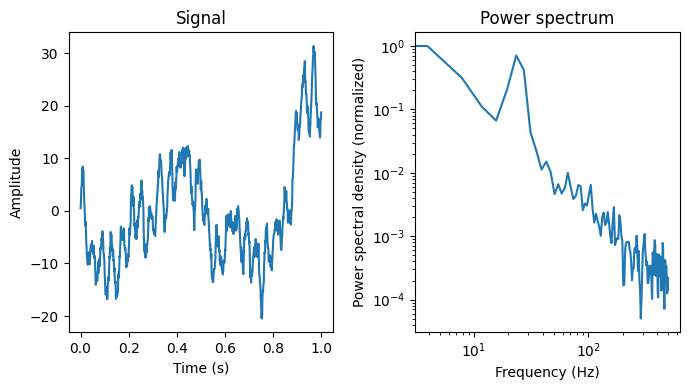

In [21]:
# provided

# Generate signal
np.random.seed(42)
sampling_frequency = 1000
duration = 1 # second
time_vec = np.arange(0, duration, 1/sampling_frequency)

f_peak = 25 # artificial peak
sig = 4*np.sin(2 * np.pi * f_peak * time_vec) + np.cumsum(np.random.randn(len(time_vec)))  # 1/f noise + peak

# compute the power spectrum
n_perseg = 256
freqs, psd_signal = signal.welch(sig, fs = sampling_frequency, noverlap=0)

# normalize the power spectrum
psd_signal_norm = psd_signal/psd_signal.max()

# plot signal and power spectrum
plot_signal_and_power_spectrum(time_vec, sig, freqs, psd_signal_norm)

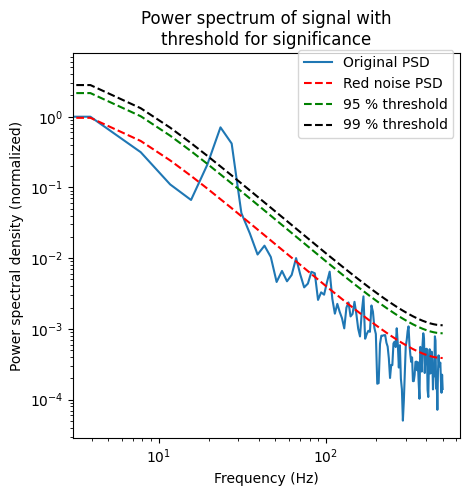

In [22]:
# solution
n_samples = sig.shape[-1]
psd_expected, psd_significance_threshold = utils.get_significance_threshold_psd(red_noise_spectrum, freqs, psd_signal_norm, n_samples, n_perseg,)

# plot computed power spectrum together with threshold for peaks
utils.plot_spectra_with_significance_threshold(freqs, psd_signal_norm, psd_expected, n_samples, n_perseg)

**Exercise**: Use an equivalent red noise spectrum to find and plot the threshold for statistical significant peaks in the power spectrum calculated for the synthetic signal below.

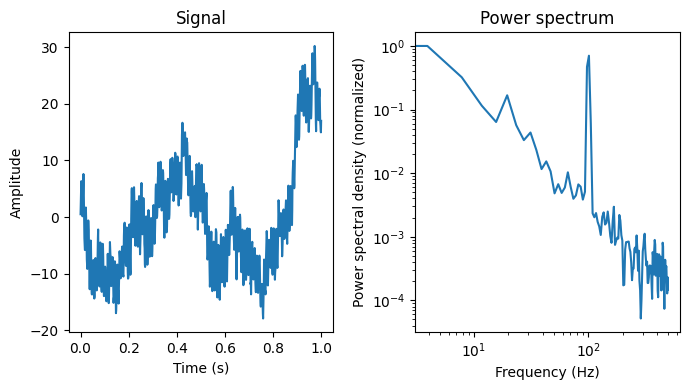

In [23]:
# provided

# Generate signal
np.random.seed(42)
sampling_frequency = 1000
duration = 1 # second
time_vec = np.arange(0, duration, 1/sampling_frequency)

f_peak = 100 # artificial peak
sig = 4*np.sin(2 * np.pi * f_peak * time_vec) + np.cumsum(np.random.randn(len(time_vec)))  # 1/f noise + peak

# compute the power spectrum
n_perseg = 256
freqs, psd_signal = signal.welch(sig, fs = sampling_frequency, noverlap=0)

# normalize the power spectrum
psd_signal_norm = psd_signal/psd_signal.max()

# plot signal and power spectrum
plot_signal_and_power_spectrum(time_vec, sig, freqs, psd_signal_norm)

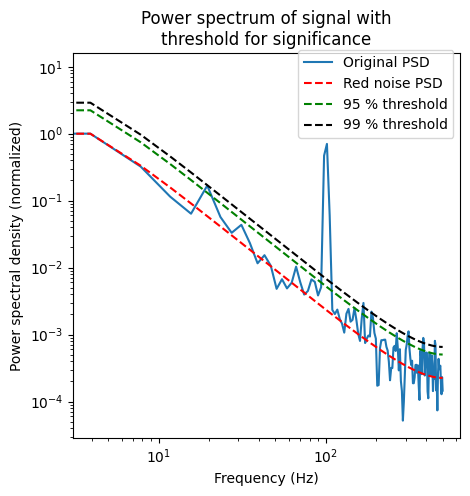

In [24]:
# solution
n_samples = sig.shape[-1]
psd_expected, psd_significance_threshold = utils.get_significance_threshold_psd(red_noise_spectrum, freqs, psd_signal_norm, n_samples, n_perseg,)

# plot computed power spectrum together with threshold for peaks
utils.plot_spectra_with_significance_threshold(freqs, psd_signal_norm, psd_expected, n_samples, n_perseg)

**Exercise**: Use an equivalent red noise spectrum to find and plot the threshold for statistical significant peaks in the power spectrum calculated from the LFP trace from channel index 6 in the first trial. 

*Hint:* Here, what needs to be changed is the ``n_samples`` parameter (to the number of samples in the LFP trace) and that it's the `psd_lfp_trace_norm` that goes into the `utils.get_significance_threshold_psd` and ``plot_spectra_with_significance_threshold`` functions.

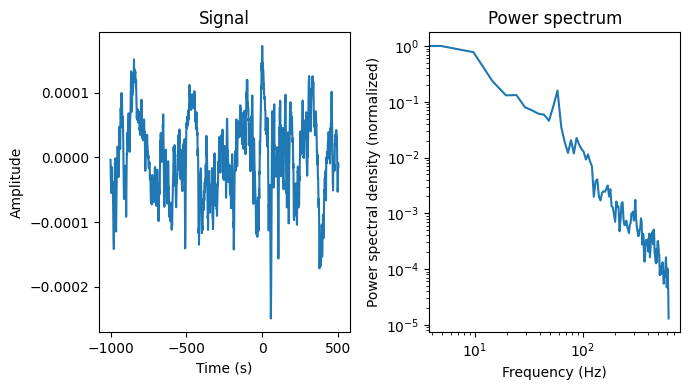

In [25]:
# provided 

itrial = 0
ichan = 5
lfp_trace = lfp_trials[ichan, itrial]
time_lfp = lfp_trials.time_from_stimulus_onset_lfp

# compute the power spectrum
n_perseg = 256
freqs, psd_lfp_trace = signal.welch(lfp_trace, fs = sampling_frequency_lfp, nperseg=n_perseg, noverlap=0)

# normalize the power spectrum
psd_lfp_trace_norm = psd_lfp_trace/psd_lfp_trace.max()

# plot signal and power spectrum
utils.plot_signal_and_power_spectrum(time_lfp, lfp_trace, freqs, psd_lfp_trace_norm)

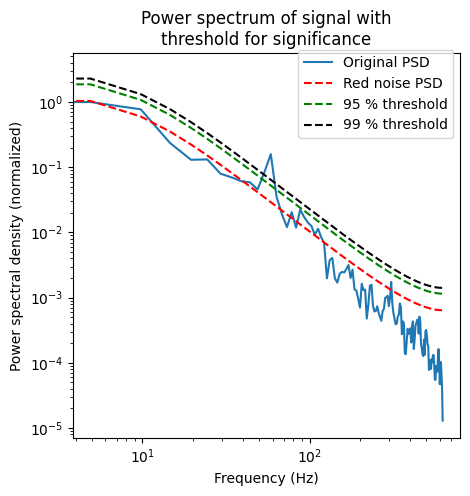

In [26]:
# solution
n_samples = lfp_trace.shape[-1]
psd_expected, psd_significance_threshold = utils.get_significance_threshold_psd(red_noise_spectrum, freqs, psd_lfp_trace_norm, n_samples, n_perseg,)

# plot computed power spectrum together with threshold for peaks
utils.plot_spectra_with_significance_threshold(freqs, psd_lfp_trace_norm, psd_expected, n_samples, n_perseg)

**Exercise**: Use an equivalent red noise spectrum to find and plot the threshold for statistical significant peaks in the **trial-averaged** power spectrum (`psd_trial_avg_norm`) calculated from the LFP traces from channel index 6. 

*Hint*: The `psd_trial_avg_norm` variables needs to go into the `get_significance_threshold_psd` and `plot_spectra_with_significance_threshold` functions.

In [27]:
# provided

lfp_traces = lfp_trials[ichan]

n_perseg = 256
freqs, psd_all_trials = signal.welch(lfp_traces, fs = sampling_frequency_lfp, nperseg=n_perseg, noverlap = 0)
psd_trial_avg = np.mean(psd_all_trials, axis=0)

# normalize the power spectrum
psd_trial_avg_norm = psd_trial_avg/psd_trial_avg.max()

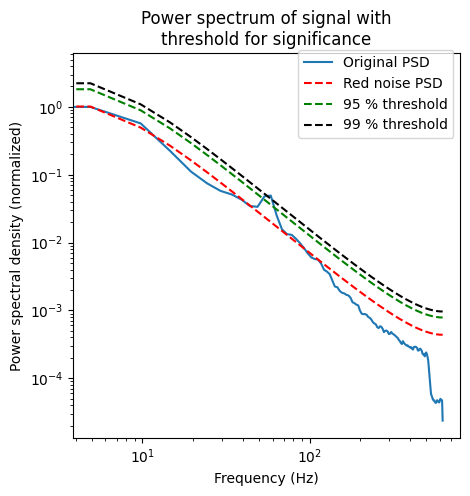

In [28]:
# solution
n_samples = lfp_trace.shape[-1]
psd_expected, psd_significance_threshold = utils.get_significance_threshold_psd(red_noise_spectrum, freqs, psd_trial_avg_norm, n_samples, n_perseg,)

# plot computed power spectrum together with threshold for peaks
utils.plot_spectra_with_significance_threshold(freqs, psd_trial_avg_norm, psd_expected, n_samples, n_perseg)

**Example**: Find the frequencies of the peak(s) in the power spectrum that are above the threshold for statistical significance with p = 0.05 as the limit. *Hint:* Find where the original PSD is greater than the threshold for significance and use that as an index or a mask for the frequencies.

In [29]:
# solution

# set threshold for significance
alpha = 0.05

n_samples = lfp_traces.shape[-1]
psd_expected, psd_significance_threshold = utils.get_significance_threshold_psd(red_noise_spectrum, freqs, psd_trial_avg_norm, 
                                                                                n_samples, n_perseg, alpha=alpha)

# find frequencies where the power spectrum is above the threshold for significance
idx_significant_freqs = np.where((psd_trial_avg_norm > psd_significance_threshold))[0]
freqs[idx_significant_freqs]

array([53.7109375, 58.59375  ])

**Exercise**: Change the ``alpha`` parameter (the threshold for significance) to p = 0.01 and find the frequencies of the peak(s) in the power spectrum that are above the threshold for statistical significance.

In [30]:
# solution


# set threshold for significance
alpha = 0.01

n_samples = lfp_traces.shape[-1]
psd_expected, psd_significance_threshold = utils.get_significance_threshold_psd(red_noise_spectrum, freqs, psd_trial_avg_norm, n_samples, n_perseg,)

# find frequencies where the power spectrum is above the threshold for significance
idx_significant_freqs = np.where((psd_trial_avg_norm > psd_significance_threshold))[0]
freqs[idx_significant_freqs]



array([53.7109375, 58.59375  ])

## Section 3

### Correcting for multiple comparisons - False Discovery Rate

Get p-values and correct for multiple comparisons.

| Code, | Description |
| :-- | :-- |
| `np.where(value=array)[0]` | Returns the index in an array at which value is located. |
| `np.sum(array < some_number)` | Counts the number of elements in the array that are smaller than `some_number`. |
| `p_values = utils.get_p_value(`<br> &nbsp;&nbsp;&nbsp;&nbsp;`idx_freqs_to_test, psd_original,`<br> &nbsp;&nbsp;&nbsp;&nbsp;`psd_expected, n_samples,`<br> &nbsp;&nbsp;&nbsp;&nbsp;`n_perseg)` | Calculates the p-values of the peaks in the spectrum `psd_original` at the frequencies selected by `idx_freqs_to_test`. |
| `p_values_adjusted =`<br> &nbsp;&nbsp;&nbsp;&nbsp;`false_discovery_control(p_values)` | Adjust the p-values by to the number of statiscal tests carried out. |
| `np.arange(start, stop, step)`   | Generates an array of values evenly spaced from `start` to `stop`, with the spacing given by `step` |                           |


In [31]:
from scipy.stats import false_discovery_control

In [32]:
# provided

lfp_traces = lfp_trials[ichan]

n_perseg = 256
freqs, psd_all_trials = signal.welch(lfp_traces, fs = sampling_frequency_lfp, nperseg=n_perseg, noverlap=0)
psd_trial_avg = np.mean(psd_all_trials, axis=0)
psd_trial_avg_norm = psd_trial_avg/psd_trial_avg.max()

n_samples = lfp_traces.shape[-1]
psd_expected, psd_significance_threshold = utils.get_significance_threshold_psd(red_noise_spectrum, freqs, psd_trial_avg_norm, n_samples, n_perseg,)

**Example**: Get the p-value of the power spectral density at 4 Hz (the frequency at index 1 in the power spectrum).

In [33]:
# solution

index_peak = 1
freq_to_test = freqs[index_peak]

idx_freqs_to_test = np.where(freqs==freq_to_test)[0]

p_values = utils.get_p_value(idx_freqs_to_test, psd_trial_avg_norm, psd_expected, n_samples, n_perseg)
print('Frequency: ', np.round(freq_to_test, 3), ', p_values: ', p_values)

Frequency:  4.883 , p_values:  [0.53966323]


**Exercise**: Change the `index_peak` variable to `12` to get the p-value for the peak at 58 Hz.

In [34]:
# solution

freq_to_test = freqs[12]

idx_freqs_to_test = np.where(freqs==freq_to_test)[0]

p_values = utils.get_p_value(idx_freqs_to_test, psd_trial_avg_norm, psd_expected, n_samples, n_perseg)
print('Frequency: ', np.round(freq_to_test, 3), ', p_values: ', p_values)

Frequency:  58.594 , p_values:  [0.00331165]


**Exercise**: Pick a frequency yourself and check the p-value for the PSD at this frequency.

**Example**: For the list of p-values below, use the function `false_discovery_control` to adjust the p-values for multiple tests and print the adjusted values.

In [35]:
# solution

pvalues = [0.01,0.001, 0.05, 0.20, 0.15, 0.15]

print(false_discovery_control(pvalues))

[0.03  0.006 0.1   0.2   0.18  0.18 ]


**Example**: Calculate the p-values for all frequencies in the spectrum and print them.

In [36]:
# solution

freq_to_test = freqs[12]

idx_freqs_to_test = np.arange(len(freqs))

p_values = utils.get_p_value(idx_freqs_to_test, psd_trial_avg_norm, psd_expected, n_samples, n_perseg)
p_values

array([0.99994182, 0.53966323, 0.37461807, 0.69768095, 0.8437394 ,
       0.83954932, 0.78209328, 0.63652386, 0.55241564, 0.5444886 ,
       0.35513474, 0.02124865, 0.00331165, 0.15382452, 0.46759615,
       0.49673076, 0.38721898, 0.40848413, 0.45124856, 0.51715939,
       0.59512566, 0.6341696 , 0.5964088 , 0.52475592, 0.58267035,
       0.70482312, 0.69319826, 0.703743  , 0.81361992, 0.88745835,
       0.86759701, 0.89620195, 0.89785377, 0.88179782, 0.87863781,
       0.86271158, 0.8756107 , 0.91624073, 0.90923993, 0.91074674,
       0.90154142, 0.94412918, 0.95738849, 0.95157662, 0.94073517,
       0.93839015, 0.94689053, 0.94399221, 0.94951468, 0.95963682,
       0.96086268, 0.95994646, 0.97019623, 0.9698779 , 0.95351399,
       0.95096988, 0.95822742, 0.97178855, 0.96026927, 0.95326415,
       0.95414415, 0.96522752, 0.95835849, 0.94013732, 0.94623332,
       0.94633128, 0.94752047, 0.95072629, 0.95313756, 0.95460715,
       0.9626944 , 0.96588426, 0.97225063, 0.97406425, 0.95528

**Exercise**: How many frequencies have p-values below 0.05 according to this naive test?

In [37]:
# solution
np.sum(p_values < 0.05)

2

**Exercise**: Above we tested every frequency in the spectrum, which means that we carried out 129 tests for significance. With this many tests, we would actually expect up to 6 frequencies to have peaks with p-values < 0.05 even if the peaks are only due to noise. Use the `false_discovery_control` function to adjust the p_values obtained above for doing multiple tests.

In [38]:
# solution
print(false_discovery_control(p_values))

[0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.4272029  0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995
 0.99999995 0.99999995 0.99999995 0.99999995 0.99999995 0.9999

**Exercise**: How many of the adjusted p-values are <0.05?

In [39]:
# solution
sum(false_discovery_control(p_values) < 0.05)

0